In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [31]:
import os
import json
import torch
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torchvision.transforms import ToTensor, Compose
from pycocotools.coco import COCO
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.ops import box_iou
from torchvision.transforms import functional as F
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


# Paths to annotation and image files
annotation_file = r"/content/drive/MyDrive/instances_default.json"
image_folder = r"/content/drive/MyDrive/PORTIMAGES"

# Validate file paths
if not os.path.exists(annotation_file):
    raise FileNotFoundError(f"Annotation file not found: {annotation_file}")
if not os.path.exists(image_folder):
    raise FileNotFoundError(f"Image folder not found: {image_folder}")

# Load JSON annotations
with open(annotation_file, 'r') as f:
    data = json.load(f)

coco = COCO(annotation_file)
print(f"Number of images: {len(data['images'])}, Number of annotations: {len(data['annotations'])}")

class CustomCocoDataset(Dataset):
    def __init__(self, img_folder, ann_file, transforms=None):
        self.img_folder = img_folder
        self.transforms = transforms

        # Load annotations
        with open(ann_file, 'r') as f:
            self.annotations = json.load(f)

        # Create a mapping from image IDs to annotations
        self.imgs = {img['id']: img for img in self.annotations['images']}
        self.annotations_by_img = {}
        for ann in self.annotations['annotations']:
            img_id = ann['image_id']
            if img_id not in self.annotations_by_img:
                self.annotations_by_img[img_id] = []
            self.annotations_by_img[img_id].append(ann)

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        # Get image info and load image
        img_id = list(self.imgs.keys())[idx]
        img_info = self.imgs[img_id]
        img_path = os.path.join(self.img_folder, img_info['file_name'])
        img = Image.open(img_path).convert("RGB")  # Ensure image is in RGB format

        # Load annotations
        annotations = self.annotations_by_img.get(img_id, [])

        # Process annotations into proper format
        boxes = []
        labels = []
        masks = []
        for ann in annotations:
            bbox = ann['bbox']
            x, y, w, h = bbox
            boxes.append([x, y, x + w, y + h])  # Convert bbox to [x_min, y_min, x_max, y_max]
            labels.append(ann['category_id'])  # Category ID as label

            # Create binary mask for each object (example here, adapt to your segmentation data)
            mask = torch.zeros(int(h), int(w), dtype=torch.uint8)  # Ensure h and w are integers
            masks.append(mask)

        # Convert boxes, labels to tensors
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        # Resize masks to match image dimensions
        if len(masks) > 0:
            max_height = max([mask.shape[0] for mask in masks])
            max_width = max([mask.shape[1] for mask in masks])
            padded_masks = []
            for mask in masks:
                padded_mask = F.resize(mask.unsqueeze(0), (max_height, max_width))  # Resize each mask to the same size
                padded_masks.append(padded_mask.squeeze(0))  # Remove extra dimension
            masks = torch.stack(padded_masks)

        # Apply transformations (if any)
        if self.transforms:
            img = self.transforms(img)

        return img, {'boxes': boxes, 'labels': labels, 'masks': masks}

# Define transforms for the dataset
def get_transform():
    return Compose([ToTensor()])

# Define Dataset and DataLoader
dataset = CustomCocoDataset(img_folder=image_folder, ann_file=annotation_file, transforms=get_transform())
data_loader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# Load Mask R-CNN model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = maskrcnn_resnet50_fpn(pretrained=True)

# Modify the classifier and mask predictor for the new number of classes
num_classes = len(data['categories']) + 1  # Add 1 for background class
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Modify the box predictor to match the number of classes
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Modify the mask predictor to match the number of classes
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
dim_reduced = 256  # You can adjust this value if needed
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_channels=in_features_mask, num_classes=num_classes, dim_reduced=dim_reduced)

model.to(device)

# Optimizer and scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = Adam(params, lr=0.001)
lr_scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

# Training Loop
epochs = 50
for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for imgs, annotations in data_loader:
        # Move images and annotations to the device
        imgs = [img.to(device) for img in imgs]
        annotations = [{'boxes': anns['boxes'].to(device), 'labels': anns['labels'].to(device), 'masks': anns['masks'].to(device)} for anns in annotations]

        # Forward pass
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())

        # Backpropagation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        # Accumulate epoch loss
        epoch_loss += losses.item()

    # Update learning rate scheduler
    lr_scheduler.step()
    print(f"Epoch {epoch + 1}/{epochs}, Average Loss: {epoch_loss / len(data_loader):.4f}")

# IoU Evaluation
def evaluate_model(model, data_loader, device):
    model.eval()
    iou_scores = []

    with torch.no_grad():
        for imgs, annotations in data_loader:
            imgs = [img.to(device) for img in imgs]

            outputs = model(imgs)

            for output, target in zip(outputs, annotations):
                pred_boxes = output['boxes'].cpu()
                true_boxes = target['boxes']

                if len(pred_boxes) > 0 and len(true_boxes) > 0:
                    iou = box_iou(pred_boxes, true_boxes)
                    max_iou, _ = torch.max(iou, dim=1)
                    valid_iou = max_iou[max_iou > 0.5]

                    if valid_iou.numel() > 0:
                        iou_scores.append(valid_iou.mean().item())

    return sum(iou_scores) / len(iou_scores) if iou_scores else 0.0

average_iou = evaluate_model(model, data_loader, device)
print(f"Average IoU: {average_iou:.4f}")


loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Number of images: 95, Number of annotations: 224
Epoch 1/50, Average Loss: 2.4507
Epoch 2/50, Average Loss: 0.3934
Epoch 3/50, Average Loss: 0.4263
Epoch 4/50, Average Loss: 0.4198
Epoch 5/50, Average Loss: 0.3757
Epoch 6/50, Average Loss: 0.3894
Epoch 7/50, Average Loss: 0.3481
Epoch 8/50, Average Loss: 0.3568
Epoch 9/50, Average Loss: 0.3346
Epoch 10/50, Average Loss: 0.3445
Epoch 11/50, Average Loss: 0.3292
Epoch 12/50, Average Loss: 0.3377
Epoch 13/50, Average Loss: 0.3383
Epoch 14/50, Average Loss: 0.3358
Epoch 15/50, Average Loss: 0.3413
Epoch 16/50, Average Loss: 0.3299
Epoch 17/50, Average Loss: 0.3363
Epoch 18/50, Average Loss: 0.3311
Epoch 19/50, Average Loss: 0.3310
Epoch 20/50, Average Loss: 0.3324
Epoch 21/50, Average Loss: 0.3348
Epoch 22/50, Average Loss: 0.3336
Epoch 23/50, Average Loss: 0.3302
Epoch 24/50, Average Loss: 0.3325
Epoch 25/50, Average Loss: 0.3365
Epoch 26/50, Average Loss: 

In [34]:
from torch.utils.data import random_split

# Define the proportion of the dataset to be used for validation
validation_split = 0.2  # 20% for validation, 80% for training

# Calculate the number of samples for each split
total_samples = len(dataset)
validation_samples = int(total_samples * validation_split)
training_samples = total_samples - validation_samples

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [training_samples, validation_samples])

# Create DataLoader for training and validation sets
train_data_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_data_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")


Training set size: 76
Validation set size: 19


In [35]:
# Training Loop with Validation
epochs = 50  # Increase the number of epochs for longer training

for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for imgs, annotations in train_data_loader:
        imgs = [img.to(device) for img in imgs]
        annotations = [{'boxes': anns['boxes'].to(device), 'labels': anns['labels'].to(device), 'masks': anns['masks'].to(device)} for anns in annotations]

        # Forward pass
        loss_dict = model(imgs, annotations)

        # Loss calculation and optimizer update
        loss = sum(loss for loss in loss_dict.values())
        epoch_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Update learning rate scheduler
    lr_scheduler.step()

  # Validation phase
model.eval()
val_loss = 0
iou_scores = []

with torch.no_grad():
    for imgs, annotations in val_data_loader:
        imgs = [img.to(device) for img in imgs]
        annotations = [{'boxes': anns['boxes'].to(device), 'labels': anns['labels'].to(device), 'masks': anns['masks'].to(device)} for anns in annotations]

        # Forward pass
        loss_dict = model(imgs, annotations)

        # Handle both list and dict cases
        if isinstance(loss_dict, list):
            val_loss += sum(loss.item() for loss in loss_dict if hasattr(loss, "item"))
        elif isinstance(loss_dict, dict):
            val_loss += sum(loss.item() for loss in loss_dict.values())

        # IoU evaluation
for output, target in zip(model(imgs), annotations):
    pred_boxes = output['boxes'].to(device)  # Move predicted boxes to the same device
    true_boxes = target['boxes'].to(device)  # Ensure ground truth boxes are on the same device

    if len(pred_boxes) > 0 and len(true_boxes) > 0:
        iou = box_iou(pred_boxes, true_boxes)  # IoU calculation
        max_iou, _ = torch.max(iou, dim=1)
        valid_iou = max_iou[max_iou > 0.5]
        if valid_iou.numel() > 0:
            iou_scores.append(valid_iou.mean().item())

# Calculate average validation IoU and loss
avg_val_iou = sum(iou_scores) / len(iou_scores) if iou_scores else 0.0
avg_val_loss = val_loss / len(val_data_loader)

# Print statistics
print(f"Epoch {epoch + 1}/{epochs}, "
      f"Train Loss: {epoch_loss / len(train_data_loader):.4f}, "
      f"Val Loss: {avg_val_loss:.4f}, "
      f"Val IoU: {avg_val_iou:.4f}")




Epoch 50/50, Train Loss: 0.3406, Val Loss: 0.0000, Val IoU: 0.6517


In [36]:
print(f"Loss Dict: {loss_dict}")


Loss Dict: [{'boxes': tensor([[  28.5719,  372.3408, 1677.5118, 1085.8289],
        [1161.2563,  501.1805, 2634.0000, 1214.3026],
        [1361.9351,   75.0297, 2211.4819, 1238.4469],
        [ 122.6190,  217.9443, 2492.2964, 1028.8854],
        [ 241.7022,  112.8063, 1079.4907, 1229.2557],
        [ 214.7338,    4.5736, 1522.3690, 1085.8973],
        [1165.8154,  365.4369, 2135.1084,  767.3707],
        [1055.7092,    6.4255, 2272.5686, 1091.3251],
        [  74.1078,  689.6683, 1071.7269, 1053.1902],
        [ 220.2219,  392.1437, 1250.4506,  789.2714],
        [ 138.4619,   84.9981, 2343.2192,  860.1812],
        [1351.4232,  505.5332, 2308.2249,  900.9863],
        [ 791.5184,  303.7203, 2141.0134, 1388.6947],
        [ 874.4615,  809.6490, 1861.5525, 1205.6006],
        [ 934.0364,  787.2938, 1566.2836, 1367.8990],
        [1289.1173,  180.6994, 1970.1143,  737.6479],
        [ 263.1380,  442.4881,  937.4420, 1044.2179],
        [1621.6636,  579.1249, 2251.9077, 1165.4453],
      

In [40]:
!pip install mediapipe


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 40.4 MB/s eta 0:00:00


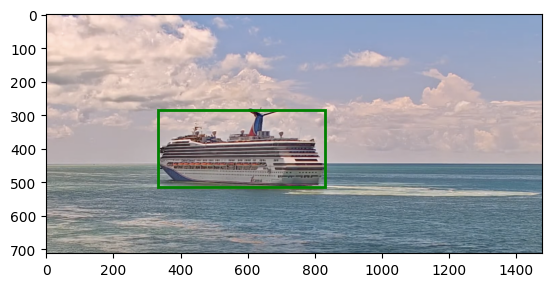

In [46]:
#visualizing predicted boxes
import matplotlib.pyplot as plt
import torchvision.transforms as T

# Function to visualize predictions
def visualize_predictions(img, target, prediction):
    img = T.ToPILImage()(img.cpu())
    plt.imshow(img)
    ax = plt.gca()

    # Draw ground truth boxes
    for box in target['boxes']:
        x1, y1, x2, y2 = box.cpu()
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='green', linewidth=2)
        ax.add_patch(rect)

    # Draw predicted boxes
    for box in prediction['boxes']:
        x1, y1, x2, y2 = box.cpu()
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='red', linewidth=2)
        # ax.add_patch(rect)

    plt.show()

# Visualize predictions on a few validation samples
for imgs, annotations in val_data_loader:
    imgs = [img.to(device) for img in imgs]
    predictions = model(imgs)

    for img, annotation, prediction in zip(imgs, annotations, predictions):
        visualize_predictions(img, annotation, prediction)
        break  # Visualize one image
    break


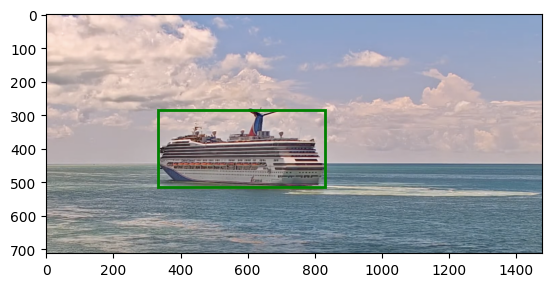

In [52]:
#visualizing predicted boxes
import matplotlib.pyplot as plt
import torchvision.transforms as T

# Function to visualize predictions
def visualize_predictions(img, target, prediction):
    img = T.ToPILImage()(img.cpu())
    plt.imshow(img)
    ax = plt.gca()

    # Draw ground truth boxes
    for box in target['boxes']:
        x1, y1, x2, y2 = box.cpu()
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='green', linewidth=2)
        ax.add_patch(rect)

    # Draw predicted boxes
    for box in prediction['boxes']:
        x1, y1, x2, y2 = box.cpu()
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='red', linewidth=2)
        # ax.add_patch(rect)

    plt.show()

# Visualize predictions on a few validation samples
for imgs, annotations in val_data_loader:
    imgs = [img.to(device) for img in imgs]
    predictions = model(imgs)

    for img, annotation, prediction in zip(imgs, annotations, predictions):
        visualize_predictions(img, annotation, prediction)
        break  # Visualize one image
    break


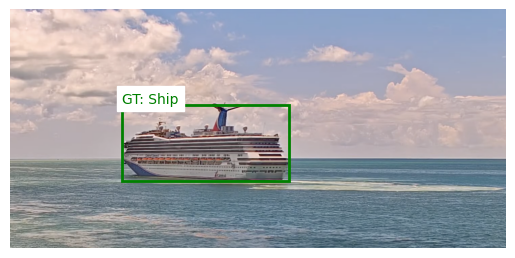

In [66]:
import matplotlib.pyplot as plt
import torchvision.transforms as T

# Parse category names from the dataset
category_mapping = {
    1: "Ship",
    2: "Yacht",
    3: "Sailboat",
    4: "Cargo ship",
    5: "Fishing boat",
    6: "Container Ship",
    7: "Speedboat"
}

# Function to visualize only ground truth boxes with category names
def visualize_ground_truth(img, target):
    img = T.ToPILImage()(img.cpu())
    plt.imshow(img)
    ax = plt.gca()

    # Draw ground truth boxes with category names
    for box, label in zip(target['boxes'], target['labels']):
        x1, y1, x2, y2 = box.detach().cpu().numpy()  # Convert to numpy
        category_name = category_mapping.get(label.item(), "Unknown")
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='green', linewidth=2)
        ax.add_patch(rect)
        ax.text(x1, y1 - 5, f"GT: {category_name}", color='green', fontsize=10, backgroundcolor='white')

    plt.axis('off')  # Turn off axis
    plt.show()

# Visualize ground truth on a few validation samples
for imgs, annotations in val_data_loader:
    imgs = [img.to(device) for img in imgs]

    for img, annotation in zip(imgs, annotations):
        visualize_ground_truth(img, annotation)
        break  # Visualize one image
    break


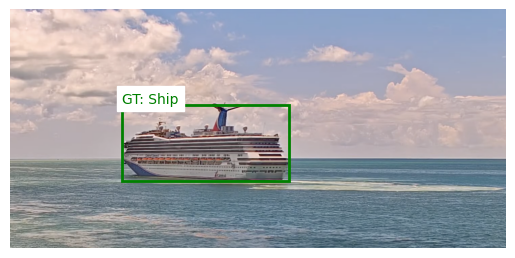

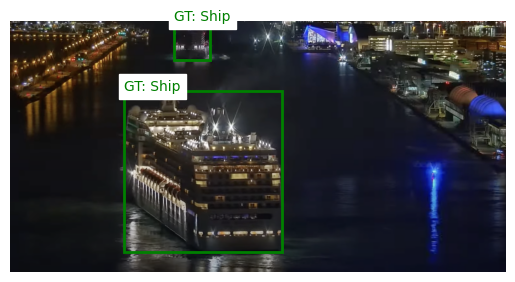

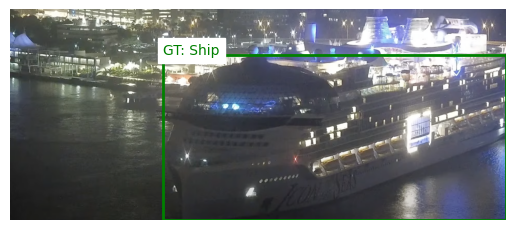

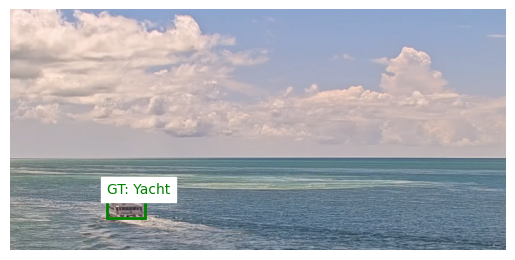

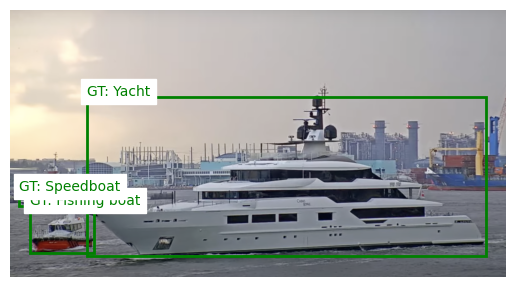

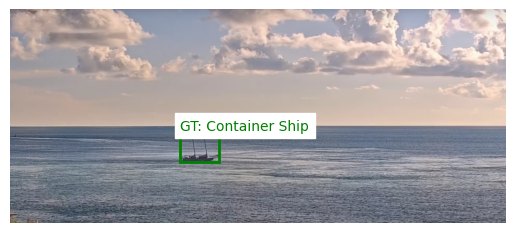

In [68]:
import matplotlib.pyplot as plt
import torchvision.transforms as T

# Parse category names from the dataset
category_mapping = {
    1: "Ship",
    2: "Yacht",
    3: "Sailboat",
    4: "Cargo ship",
    5: "Fishing boat",
    6: "Container Ship",
    7: "Speedboat"
}

# Function to visualize only ground truth boxes with category names
def visualize_ground_truth(img, target):
    img = T.ToPILImage()(img.cpu())
    plt.imshow(img)

    # Draw ground truth boxes with category names
    for box, label in zip(target['boxes'], target['labels']):
        x1, y1, x2, y2 = box.detach().cpu().numpy()  # Convert to numpy
        category_name = category_mapping.get(label.item(), "Unknown")
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='green', linewidth=2)
        plt.gca().add_patch(rect)
        plt.text(x1, y1 - 5, f"GT: {category_name}", color='green', fontsize=10, backgroundcolor='white')

    plt.axis('off')  # Turn off axis
    plt.show()

# Visualize ground truth on multiple validation images
for idx, (imgs, annotations) in enumerate(val_data_loader):
    if idx == 3:  # Stop after showing 3 images
        break

    imgs = [img.to(device) for img in imgs]

    for img, annotation in zip(imgs, annotations):
        visualize_ground_truth(img, annotation)


In [47]:
torch.save(model.state_dict(), "trained_model.pth")
print("Model saved successfully!")


Model saved successfully!


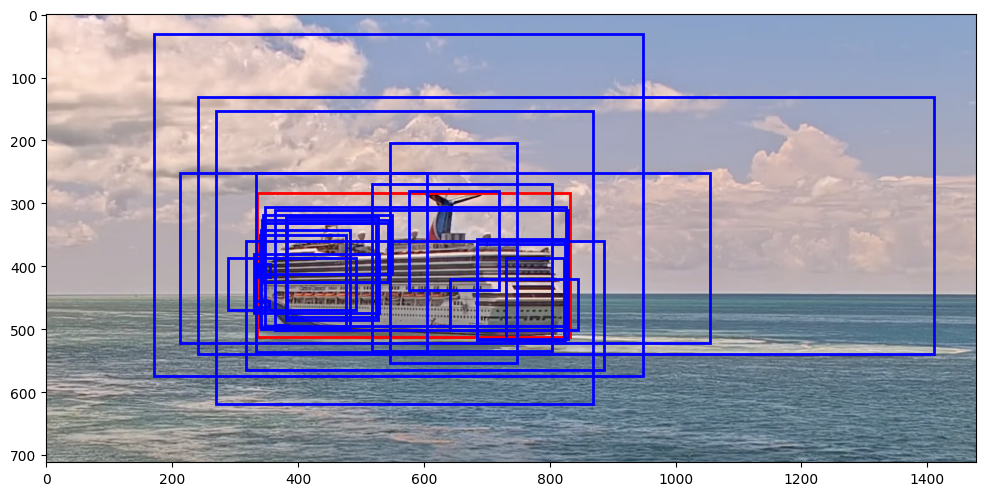

In [49]:
import matplotlib.pyplot as plt
import random
from matplotlib import patches

# Function to visualize predictions
def visualize_predictions(data_loader, model, device, scale_factor=0.9):
    model.eval()
    with torch.no_grad():
        # Select a random batch from the validation set
        data_iter = iter(data_loader)
        imgs, targets = next(data_iter)

        # Move images and annotations to device
        imgs = [img.to(device) for img in imgs]
        targets = [{'boxes': anns['boxes'].to(device), 'labels': anns['labels'].to(device), 'masks': anns['masks'].to(device)} for anns in targets]

        # Predict
        prediction = model(imgs)

        # Plot the first image in the batch
        img = imgs[0].cpu()
        target = targets[0]

        fig, ax = plt.subplots(1, figsize=(12, 9))
        ax.imshow(img.permute(1, 2, 0).numpy())

        # Plot ground truth boxes
        true_boxes = target['boxes'].cpu()
        for box in true_boxes:
            rect = patches.Rectangle(
                (box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='r', facecolor='none'
            )
            ax.add_patch(rect)

        # Plot predicted boxes with scaling
        pred_boxes = prediction[0]['boxes'].cpu()
        for box in pred_boxes:
            # Apply the scaling factor to the predicted box
            x1, y1, x2, y2 = box
            width = (x2 - x1) * scale_factor
            height = (y2 - y1) * scale_factor

            # Adjust the coordinates to center the scaled box
            x1 = x1 + (x2 - x1 - width) / 2
            y1 = y1 + (y2 - y1 - height) / 2
            x2 = x1 + width
            y2 = y1 + height

            rect = patches.Rectangle(
                (x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='b', facecolor='none'
            )
            ax.add_patch(rect)

        plt.show()

# Visualize a few predictions from validation set with scaled boxes
visualize_predictions(val_data_loader, model, device)


In [50]:
from sklearn.metrics import average_precision_score

def compute_average_precision(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, targets in data_loader:
            imgs = [img.to(device) for img in imgs]
            targets = [{'boxes': anns['boxes'].to(device), 'labels': anns['labels'].to(device), 'masks': anns['masks'].to(device)} for anns in targets]

            # Get model predictions
            predictions = model(imgs)

            # Collect true labels and predicted scores
            for i in range(len(targets)):
                true_labels = targets[i]['labels'].cpu().numpy()
                pred_scores = predictions[i]['scores'].cpu().numpy()
                pred_labels = predictions[i]['labels'].cpu().numpy()

                # Convert to one-hot format for multi-class precision
                for cls in range(len(true_labels)):
                    all_preds.append(pred_scores[cls] if pred_labels[cls] == true_labels[cls] else 0)
                    all_labels.append(1 if pred_labels[cls] == true_labels[cls] else 0)

    # Calculate Average Precision (AP)
    ap = average_precision_score(all_labels, all_preds)
    print(f"Average Precision (AP): {ap:.4f}")
    return ap

# Compute Average Precision
compute_average_precision(model, val_data_loader, device)


Average Precision (AP): 1.0000


0.9999999999999998

In [51]:
torch.save(model.state_dict(), 'model.pth')
print("Model saved successfully!")


Model saved successfully!
